# InternVLA-N1 Model Inferring Notebook

This notebook is used to infer the InternVLA-N1 model's by reading images and instructions from local folders. If you'd like to test the model in real world or self-built dataset, you could follow this tutorial without large **datasets download** and **simulation environment setup** (isaac-sim or habitat). Let's start!

## 0. Preparation
### 0.0 Create Conda Environment
First, we should create a conda environment through `conda create -n internvla python=3.9` and launch the jupyter kernel using the created environment. In the following tutorial, we assume the environment name is `internvla`. 

In [ ]:
%pip install torch==2.6.0 torchvision==0.21.0 --index-url https://download.pytorch.org/whl/cu124
import torch
print(torch.__version__)

We recommend to install flash-attn2 via pre-built wheel. If you have trouble with the installation, you might also skip this installation and remove the line of `attn_implementation="flash_attention_2"` in the model initialization.

In [ ]:
!wget https://github.com/Dao-AILab/flash-attention/releases/download/v2.7.3/flash_attn-2.7.3+cu12torch2.6cxx11abiFALSE-cp39-cp39-linux_x86_64.whl
%pip install flash_attn-2.7.3+cu12torch2.6cxx11abiFALSE-cp39-cp39-linux_x86_64.whl 

In [ ]:
%pip install transformers==4.51.0 diffusers==0.31.0 accelerate==1.10.1 opencv-python==4.10.0.82 pillow==10.4.0 numpy==1.26.4 gym==0.23.1
%pip install imageio==2.37.0 imageio-ffmpeg==0.6.0 ftfy==6.3.1
%pip install scipy matplotlib
%pip install -e ../../. # install InternNav 

### 0.1 Prepare the dataset for inference

In [ ]:
!tar -xvf ../../assets/realworld_sample_data.tar.gz -C ../../assets/

### 0.2 Download checkpoint
The size of checkpoint is about 8GB.

In [ ]:
!mkdir -p checkpoints && cd checkpoints && git clone https://huggingface.co/InternRobotics/InternVLA-N1-DualVLN
!git lfs pull

### 0.3 Download the DepthAnything checkpoint
Download the depthanything checkpoint from [DepthAnything](https://huggingface.co/depth-anything/Depth-Anything-V2-Metric-Hypersim-Small) and move it into `scripts/eval/checkpoints/checkpoints` folder.

## 1. Import Required Libraries
If you meet the error about the `No module named LongCLIP (or diffusion policy)`, you should run the `git submodule update --init` in the root directory of InternNav. 

In [ ]:
import sys
import os
import glob
from pathlib import Path

import numpy as np
from PIL import Image
import torch

# Add project path
project_root = Path('../../')
sys.path.insert(0, str(project_root))
sys.path.insert(0, str(project_root / 'src/diffusion-policy'))

from internnav.agent.internvla_n1_agent_realworld import InternVLAN1AsyncAgent

## 2. Configure Parameters
Change the checkpoint path of InternVLA-N1 to the exact path in your computer. In real-world experiment, too fast inference will lead to overly close the memory intervals of the model, resulting in a large sim-to-real gap. Therefore, we use an argument `plan_step_gap` to make the model only infer every `plan_step_gap` frames when outputing trajectories. 

In [ ]:
class Args:
    def __init__(self):
        self.device = "cuda:0"
        self.model_path = "/home/pjlab/fengdelin/data/InternVLA-N1-DualVLN"
        self.resize_w = 384
        self.resize_h = 384
        self.num_history = 8
        self.camera_intrinsic = np.array([
            [386.5, 0.0, 328.9, 0.0],
            [0.0, 386.5, 244.0, 0.0],
            [0.0, 0.0, 1.0, 0.0],
            [0.0, 0.0, 0.0, 1.0]
        ])
        self.plan_step_gap = 4

args = Args()
print(f"Model path: {args.model_path}")
print(f"Device: {args.device}")
print(f"Image size: {args.resize_w}x{args.resize_h}")
print(f"History frames: {args.num_history}")

## 3. Initialize Agent
Load the InternVLA-N1 model and initialize the agent. If you meet error about transformers, please check that the `flash_attn` and `accelerate` is correctly installed.

In [ ]:
print("Loading model...")
agent = InternVLAN1AsyncAgent(args)

# Warm up model
print("Warming up model...")
dummy_rgb = np.zeros((480, 640, 3), dtype=np.uint8)
dummy_depth = np.zeros((480, 640), dtype=np.float32)
dummy_pose = np.eye(4)
agent.reset()
agent.step(dummy_rgb, dummy_depth, dummy_pose, "hello", intrinsic=args.camera_intrinsic)
print("Model loaded successfully!")

## 4. Configure Test Data Path
Now we used a pre-collected real-world dataset to test our model. The images were captured through a Unitree Go2 robot mounted with a realsense D455. You could freely change the dataset to your own dataset and an `instruction.txt` file. Note that the `InternVLA-N1` model use depth image inputs for S1 model, but we forgot recording the depth image in real-world dataset. If you want to build your own dataset, please record **both the aligned depth and rgb images**. 

In [ ]:
# Configure data directory (single scene per folder)
scene_dir = '../../assets/realworld_sample_data1'

# Check if instruction file exists
instruction_path = os.path.join(scene_dir, 'instruction.txt')
if not os.path.exists(instruction_path):
    print(f"Error: instruction.txt not found in {scene_dir}")
else:
    print(f"Scene directory: {scene_dir}")
    
    # Read instruction
    with open(instruction_path, 'r') as f:
        instruction = f.read().strip()
    print(f"Instruction: {instruction}")
    
    # Get all debug_raw images
    rgb_paths = sorted(glob.glob(os.path.join(scene_dir, 'debug_raw_*.jpg')))
    print(f"\nFound {len(rgb_paths)} images")
    # Show first few image names
    print("\nFirst 5 images:")
    for i, path in enumerate(rgb_paths[:5]):
        print(f"  {i+1}. {os.path.basename(path)}")

Now add some visualization function for the model.

In [5]:
from PIL import Image, ImageDraw, ImageFont
import cv2

def annotate_image(idx, image, llm_output, trajectory, pixel_goal, output_dir):
    image = Image.fromarray(image)#.save(f'rgb_{idx}.png')
    draw = ImageDraw.Draw(image)
    font_size = 20
    font = ImageFont.truetype("DejaVuSansMono.ttf", font_size)
    text_content = []
    text_content.append(f"Frame    Id  : {idx}")
    text_content.append(f"Actions      : {llm_output}" )
    max_width = 0
    total_height = 0
    for line in text_content:
        bbox = draw.textbbox((0, 0), line, font=font)
        text_width = bbox[2] - bbox[0]
        text_height = 26
        max_width = max(max_width, text_width)
        total_height += text_height

    padding = 10
    box_x, box_y = 10, 10
    box_width = max_width + 2 * padding
    box_height = total_height + 2 * padding

    draw.rectangle([box_x, box_y, box_x + box_width, box_y + box_height], fill='black')

    text_color = 'white'
    y_position = box_y + padding
    
    for line in text_content:
        draw.text((box_x + padding, y_position), line, fill=text_color, font=font)
        bbox = draw.textbbox((0, 0), line, font=font)
        text_height = 26
        y_position += text_height
    image = np.array(image)
    
    # Draw trajectory visualization in the top-right corner using matplotlib
    if trajectory is not None and len(trajectory) > 0:
        import matplotlib.pyplot as plt
        from matplotlib.backends.backend_agg import FigureCanvasAgg
        
        img_height, img_width = image.shape[:2]
        
        # Window parameters
        window_size = 200  # Window size in pixels
        window_margin = 0  # Margin from edge
        window_x = img_width - window_size - window_margin
        window_y = window_margin
        
        # Extract trajectory points
        traj_points = []
        for point in trajectory:
            if isinstance(point, (list, tuple, np.ndarray)) and len(point) >= 2:
                traj_points.append([float(point[0]), float(point[1])])
        
        if len(traj_points) > 0:
            traj_array = np.array(traj_points)
            x_coords = traj_array[:, 0]
            y_coords = traj_array[:, 1]
            
            # Create matplotlib figure
            fig, ax = plt.subplots(figsize=(2, 2), dpi=100)
            fig.patch.set_alpha(0.6)  # Semi-transparent background
            fig.patch.set_facecolor('gray')
            ax.set_facecolor('lightgray')
            
            # Plot trajectory
            # Coordinate system: x-axis points up, y-axis points left
            # Origin at bottom center
            ax.plot(y_coords, x_coords, 'b-', linewidth=2, label='Trajectory')
            
            # Mark start point (green) and end point (red)
            ax.plot(y_coords[0], x_coords[0], 'go', markersize=6, label='Start')
            ax.plot(y_coords[-1], x_coords[-1], 'ro', markersize=6, label='End')
            
            # Mark origin
            ax.plot(0, 0, 'w+', markersize=10, markeredgewidth=2, label='Origin')
            
            # Set axis labels
            ax.set_xlabel('Y (left +)', fontsize=8)
            ax.set_ylabel('X (up +)', fontsize=8)
            ax.invert_xaxis()
            ax.tick_params(labelsize=6)
            ax.grid(True, alpha=0.3, linewidth=0.5)
            
            # Set equal aspect ratio
            ax.set_aspect('equal', adjustable='box')
            
            # Add legend
            ax.legend(fontsize=6, loc='upper right')
            
            # Adjust layout
            plt.tight_layout(pad=0.3)
            
            # Convert matplotlib figure to numpy array
            canvas = FigureCanvasAgg(fig)
            canvas.draw()
            plot_img = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
            plot_img = plot_img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            plt.close(fig)
            
            # Resize plot to fit window
            plot_img = cv2.resize(plot_img, (window_size, window_size))
            
            # Overlay plot on image
            image[window_y:window_y+window_size, window_x:window_x+window_size] = plot_img
    
    if pixel_goal is not None:
        cv2.circle(image, (pixel_goal[1], pixel_goal[0]), 5, (255, 0, 0), -1)
    image = Image.fromarray(image).convert('RGB')
    image.save(f'{output_dir}/rgb_{idx}_annotated.png')
    # to numpy array
    return np.array(image)

## 5. Run Model Testing
We begin to read the local images, instruction to run the model. Please make sure that the depth image is fed to the model and **the unit is in meter**. You could print the maximum value of the depth image in your real-world experiment and check the value. 

If everything goes well, the model will rotate in place at the begining. Then it generates the correct pixel goal and trajectories. The visualization results are also saved in the `save_dir` folder.

In [6]:
# Reset agent
agent.reset()
print(f"{'='*80}")
print(f"Processing scene: {os.path.basename(scene_dir)}")
print(f"Instruction: '{instruction}'")
print(f"Total images: {len(rgb_paths)}")
print(f"{'='*80}\n")

action_seq = []
look_down = False

save_dir = '../../test_data/'
os.makedirs(save_dir, exist_ok=True)
# Process each image
for i, rgb_path in enumerate(rgb_paths):
    # Check if this is a look_down image
    look_down = ('look_down' in rgb_path)
    
    # Extract image ID from filename (e.g., debug_raw_0003.jpg -> 0003)
    basename = os.path.basename(rgb_path)
    if look_down:
        # e.g., debug_raw_0010_look_down.jpg -> 0010
        image_id = basename.replace('debug_raw_', '').replace('_look_down.jpg', '')
    else:
        # e.g., debug_raw_0003.jpg -> 0003
        image_id = basename.replace('debug_raw_', '').replace('.jpg', '')
        
    # Read RGB image
    rgb = np.asarray(Image.open(rgb_path).convert('RGB'))
    
    # Create dummy depth image (not available in test data)
    # !Note You must full in depth to model
    depth = 10 * np.ones((rgb.shape[0], rgb.shape[1]), dtype=np.float32)
    
    # Create dummy camera pose
    camera_pose = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])
    
    # Run model or just save image
    # print(f"[{i+1}/{len(rgb_paths)}] Running model inference: {os.path.basename(rgb_path)}")
    with torch.no_grad():   
        dual_sys_output = agent.step(
            rgb, 
            depth, 
            camera_pose, 
            instruction, 
            intrinsic=args.camera_intrinsic,
            look_down=look_down
        )
    
    # Print output results
    if dual_sys_output.output_action is not None and dual_sys_output.output_action != []:
        print(f"  Output action: {dual_sys_output.output_action}")
        # action_seq.extend(s2_output.output_action)
    else:
        
        print(f"output_trajectory: {dual_sys_output.output_trajectory.tolist()}")
        if dual_sys_output.output_pixel is not None:
            print(f"output_pixel: {dual_sys_output.output_pixel}")
            annotate_image(image_id, rgb, 'traj', dual_sys_output.output_trajectory.tolist(), dual_sys_output.output_pixel, save_dir)


print(f"\nScene {os.path.basename(scene_dir)} completed!")


Processing scene: realworld_sample_data1
Instruction: 'Turn around and walk out of this office. Turn towards your slight right at the chair. Move forward to the walkway and go near the red bin. You can see an open door on your right side, go inside the open door. Stop at the computer monitor.'
Total images: 152

output 1  →→→→ cost: 0.18434572219848633s
  Output action: [3, 3, 3, 3]
output 2  →→→→ cost: 0.1825401782989502s
  Output action: [3, 3, 3, 3]
output 3  →→→→ cost: 0.2080528736114502s
  Output action: [3, 3, 3, 3]
output 4  →→→→ cost: 0.24245953559875488s
  Output action: [3, 3, 3, 3]
output 5  →→→→ cost: 0.27033138275146484s
  Output action: [3, 3, 3, 3]
output 6  →→→→ cost: 0.30703306198120117s
  Output action: [3, 3, 3, 3]
output 7  →→→→ cost: 0.3269386291503906s
  Output action: [3, 3, 3, 3]
output 8  →→→→ cost: 0.37332797050476074s
  Output action: [3, 3, 3, 3]
output 9  →→→→ cost: 0.39402103424072266s
  Output action: [3, 3, 3, 3]
output 10  ↓ cost: 0.3277595043182373s
  

/tmp/ipykernel_63135/3632390943.py:99: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  plot_img = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)


output_trajectory: [[0.0, 0.0], [0.10174560546875, -0.0021262168884277344], [0.2030487060546875, -0.008135795593261719], [0.3041839599609375, -0.015857279300689697], [0.405426025390625, -0.02214580774307251], [0.506927490234375, -0.023593485355377197], [0.6083984375, -0.017211496829986572], [0.70843505859375, -0.004626333713531494], [0.8078155517578125, 0.012145936489105225], [0.906158447265625, 0.03255265951156616], [1.0032196044921875, 0.05704110860824585], [1.098358154296875, 0.0870322585105896], [1.1915283203125, 0.12381595373153687], [1.28155517578125, 0.16996997594833374], [1.3683929443359375, 0.221796452999115], [1.4533538818359375, 0.277399480342865], [1.5370635986328125, 0.33464282751083374], [1.61981201171875, 0.39309924840927124], [1.7007598876953125, 0.45379871129989624], [1.7807464599609375, 0.51595538854599], [1.8596649169921875, 0.5800651907920837], [1.9368743896484375, 0.64583820104599], [2.0137100219726562, 0.7126182913780212], [2.0897674560546875, 0.780085027217865], 

/home/pjlab/miniconda3/envs/dual/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/pjlab/miniconda3/envs/dual/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.001` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/home/pjlab/miniconda3/envs/dual/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


output 17  ↓ cost: 0.3270602226257324s
  Output action: [5]
output 18  ↓ cost: 0.3256418704986572s
  Output action: [5]
output 18  215 206 cost: 0.5507287979125977s
output_trajectory: [[0.0, 0.0], [0.1019287109375, 0.0010932683944702148], [0.203887939453125, -0.0023893117904663086], [0.3053741455078125, -0.008811354637145996], [0.407012939453125, -0.01560676097869873], [0.5088043212890625, -0.019883036613464355], [0.610382080078125, -0.01963937282562256], [0.7115325927734375, -0.014272332191467285], [0.8121185302734375, -0.003148198127746582], [0.9121551513671875, 0.012552142143249512], [1.0120697021484375, 0.032639384269714355], [1.110626220703125, 0.056949496269226074], [1.20831298828125, 0.08454310894012451], [1.3054962158203125, 0.11432826519012451], [1.4022064208984375, 0.1465243101119995], [1.4980010986328125, 0.18221843242645264], [1.592620849609375, 0.22074687480926514], [1.6868743896484375, 0.26006877422332764], [1.7809295654296875, 0.29829204082489014], [1.8752288818359375, 0

# 6.Visualize Results
It's worth noting that we input an zero depth image to the model, so the output trajectories are short. In your own experiments, please check the output lengths of the model are about **2m**. If not, you should check the model inputs or create au issue on Github.

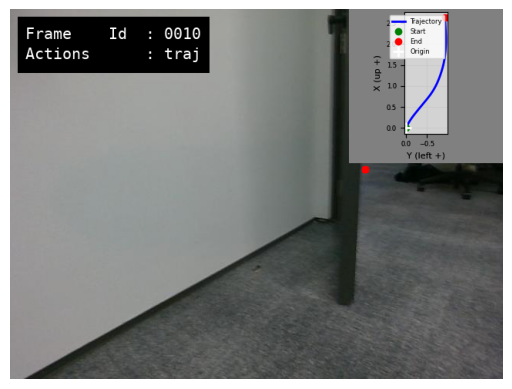

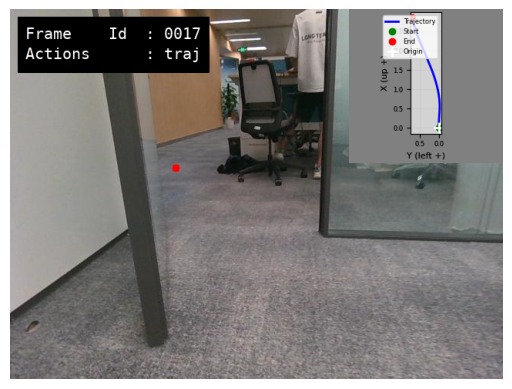

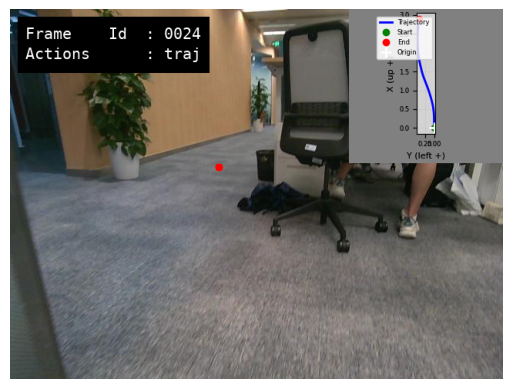

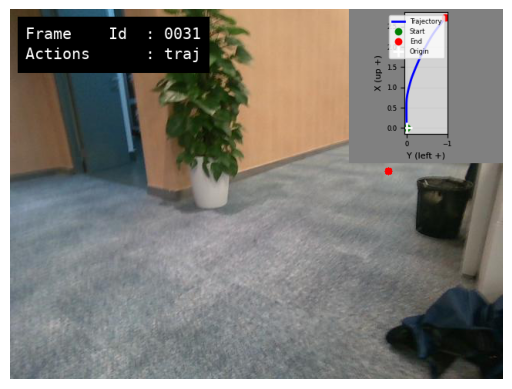

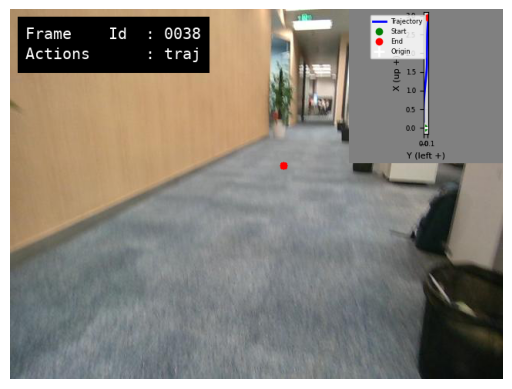

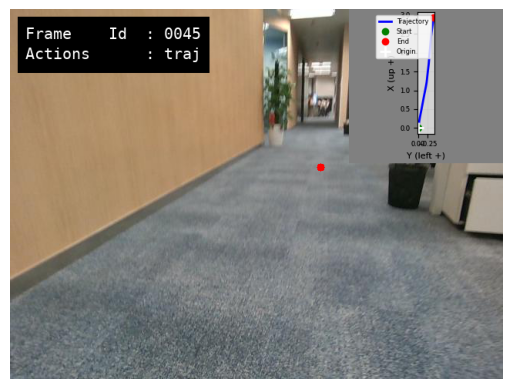

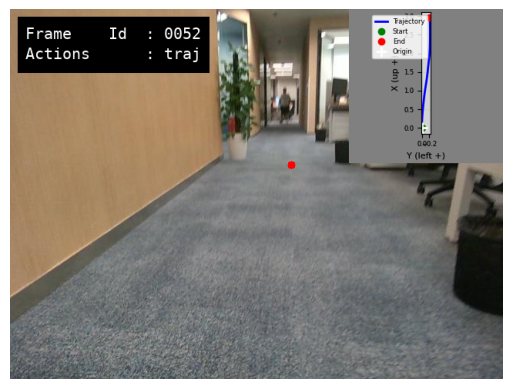

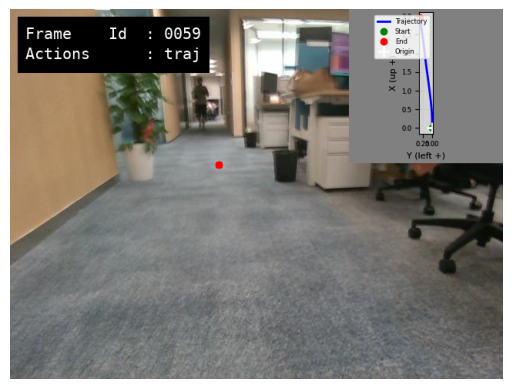

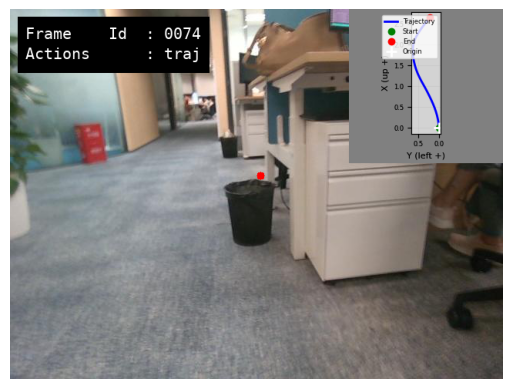

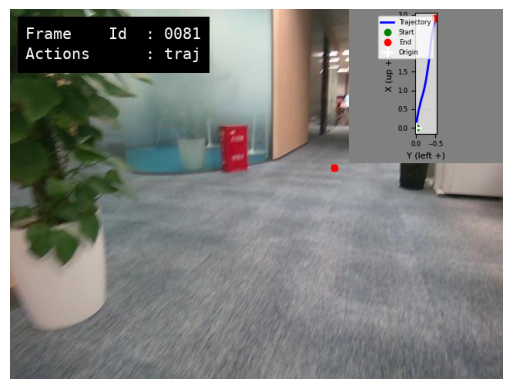

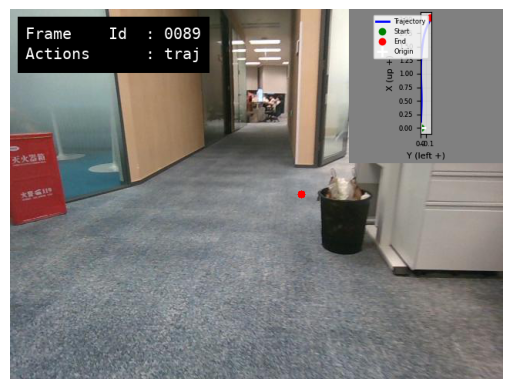

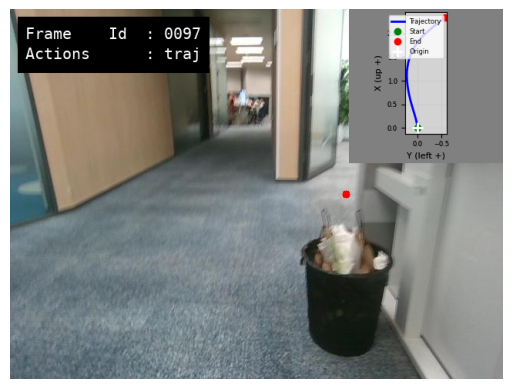

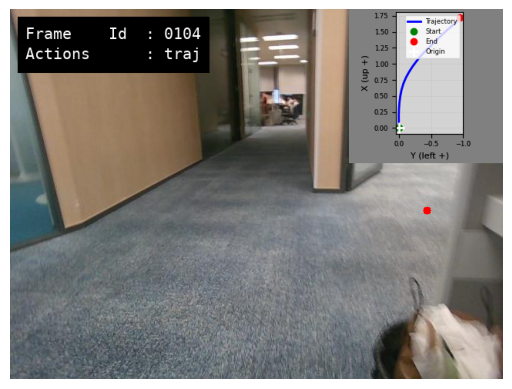

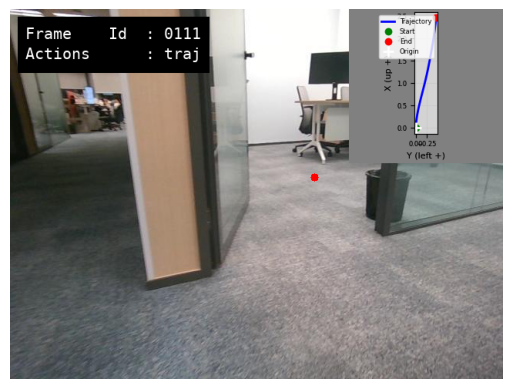

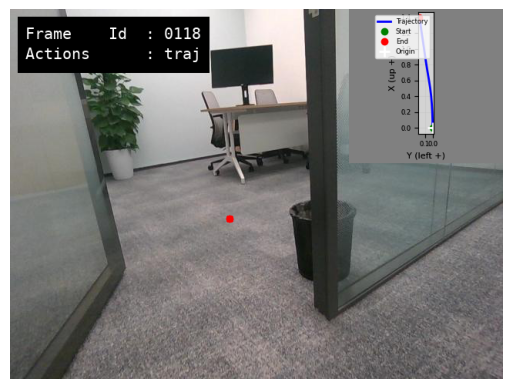

In [7]:

import glob
from PIL import Image
import matplotlib.pyplot as plt

for img_path in sorted(glob.glob(f'{save_dir}/*_annotated.png')):
    plt.imshow(Image.open(img_path))
    plt.axis('off')
    plt.show()